# Stroke Prediction Dataset

**11 clinical features for predicting stroke events**

*В данном исследовании попробуем предсказать инсульт у пациента, опираясь на различные характеристики. Датасет взят с [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)*

## Содержание <a class="anchor" id="0"></a>

1. [Описание признаков](#1)
2. [Импорты библиотек](#2)
3. [Загрузка датасета](#3)
4. [Исследование датасета](#4)
5. [Моделирование](#5)
6. [Интерпретация](#6)
7. [Заключение](#7)

## 1. Описание признаков <a class="anchor" id="1"></a>
[Наверх](#0)

1) **id**: *уникальный идентификатор*
2) **gender**: *пол пациента*
3) **age**: *возраст пациента*
4) **hypertension**: *наличие гипертензии у пациента*
5) **heart_disease**: *наличие сердечных заболеваний у пациента*
6) **ever_married**: *семейное положение*
7) **work_type**: *вид работы*
8) **Residence_type**: *место жительства*
9) **avg_glucose_level**: *средний уровень глюкозы в крови*
10) **bmi**: *индекс массы тела*
11) **smoking_status**: *статус курения*
12) **stroke**: *наличие инсульта у пациента*

## 2. Импорты библиотек <a class="anchor" id="2"></a>
[Наверх](#0)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score, 
    recall_score, 
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## 3. Загрузка датасета <a class="anchor" id="3"></a>
[Наверх](#0)

Импортируем необходимые модули для работы с файлами и API Kaggle

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path
from zipfile import ZipFile

Определим две константы. **DATASET_NAME** берём из Kaggle API команды, а в **PATH** запишем каталог, в который сохраним csv-файл с датасетом

In [3]:
DATASET_NAME = 'fedesoriano/stroke-prediction-dataset'
PATH = 'data'

In [4]:
def load_dataset():
    if not Path(PATH).is_dir():
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files(DATASET_NAME, path=PATH)
        zip_path = PATH + '/' + DATASET_NAME.split('/')[1] + '.zip'
        with ZipFile(zip_path, 'r') as zip:
            zip.extractall(PATH)
        Path(zip_path).unlink(missing_ok=True)
        print('Файл успешно загружен')
    return pd.read_csv(Path(PATH).iterdir().__next__(), sep=',')

In [5]:
stroke = load_dataset()

## 4. Исследование датасета <a class="anchor" id="4"></a>
[Наверх](#0)

In [6]:
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Оценим размер датасета

In [7]:
stroke.shape

(5110, 12)

In [8]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Как видно, пропуски только в **bmi**. По остальным признакам пропуски отсутствуют

In [9]:
stroke.describe(include=object)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


В **gender** мы видим 3 пола! Рассмотрим данный признак подробнее

In [10]:
stroke.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

У одного из пациентов в качестве пола указано _Other_. Заменим _Other_ на _Female_

In [11]:
stroke.replace('Other', 'Female', inplace=True)

In [12]:
stroke.gender.value_counts()

Female    2995
Male      2115
Name: gender, dtype: int64

In [13]:
stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Можно увидеть, что инсульт был примерно у 5% испытуемых. Примерно столько же человек страдает от сердечных заболеваний. Повышенное давление наблюдается примерно у 10% пациентов. Средний возраст составляет 43 года.

Проверим датасет на дубликаты

In [14]:
stroke.duplicated().sum()

0

Отлично, дубликатов нет!

Удалим сразу столбец **id**, так как он не представляет никакого интереса

In [15]:
stroke.drop('id', axis=1, inplace=True)

Далее рассмотрим, как распределены инсульты по разным группам пациентов

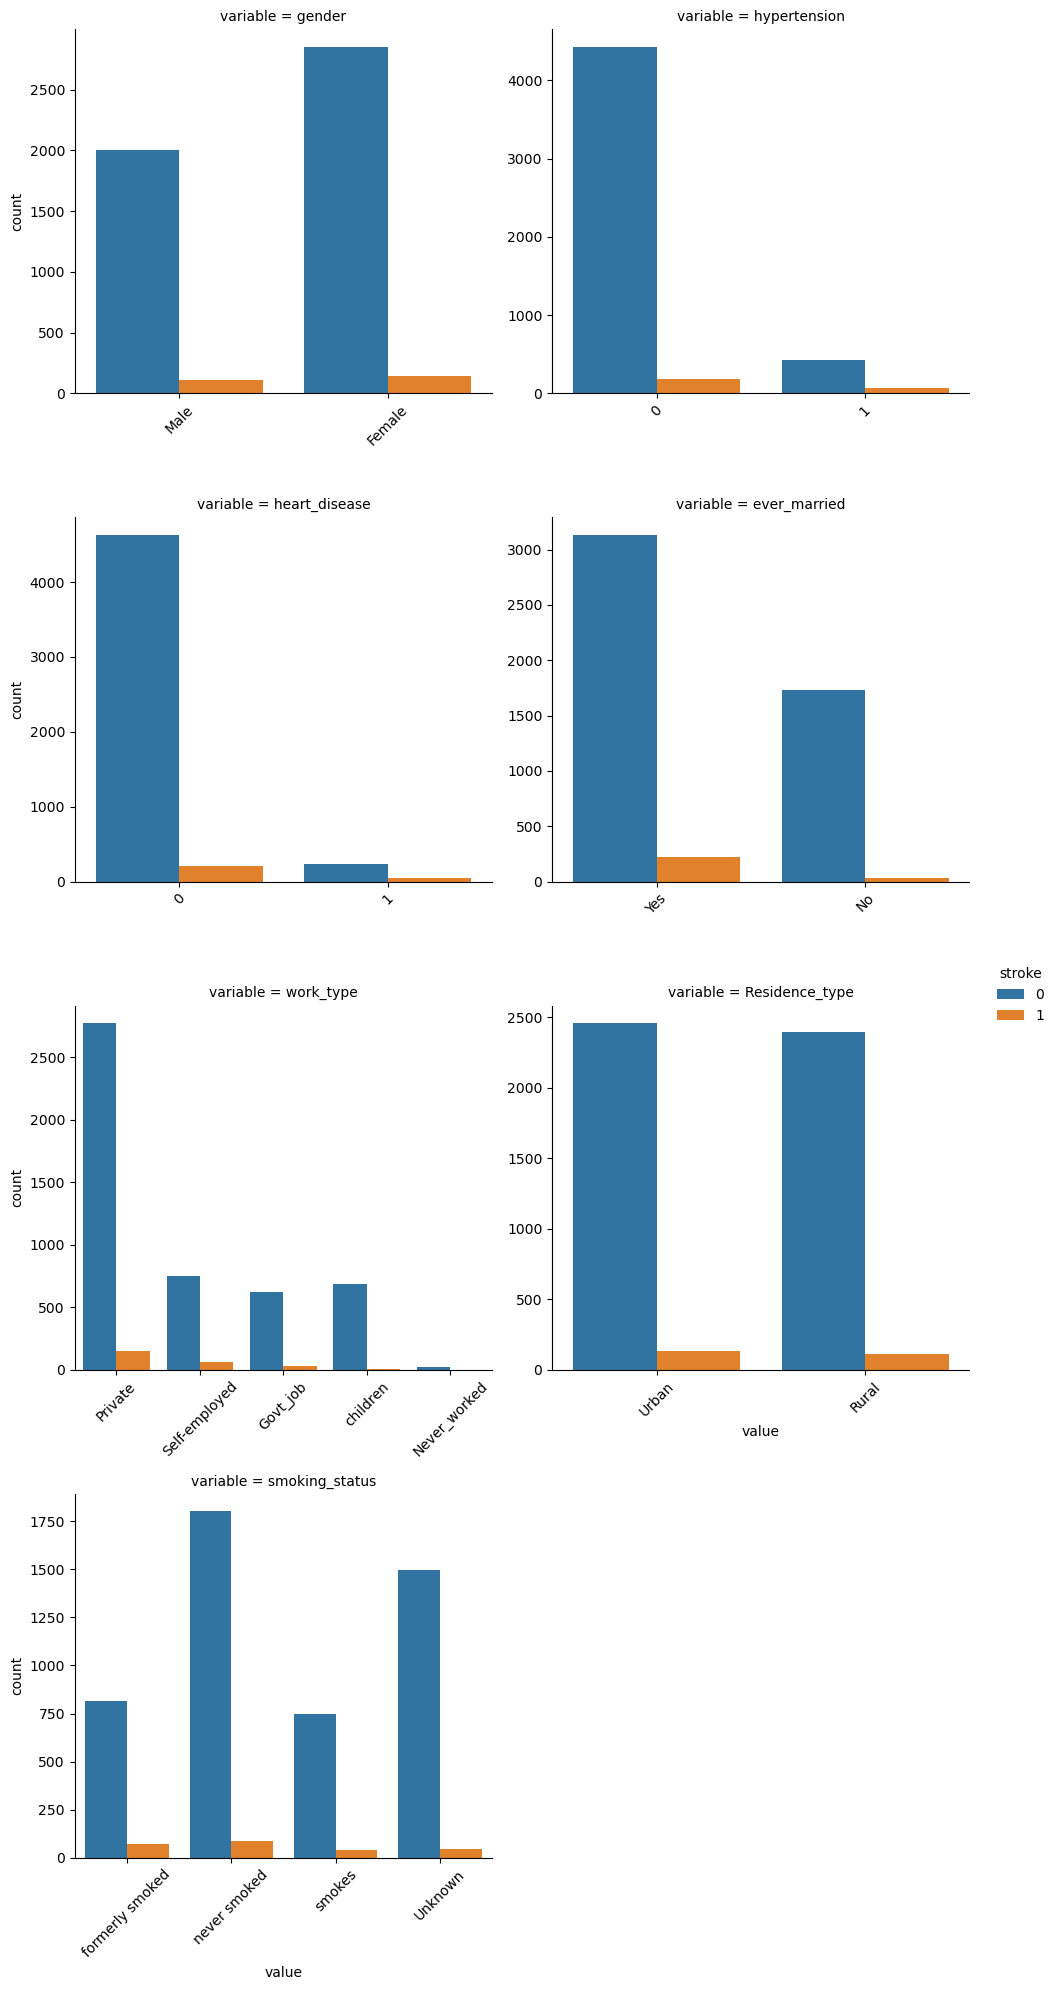

In [16]:
g=sns.catplot(
    x='value',
    hue='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes([object, int])
    ),
    col='variable',
    kind='count',
    col_wrap=2,
    sharex=False,
    sharey=False,
)
g.set_xticklabels(rotation=45)
g.tight_layout();

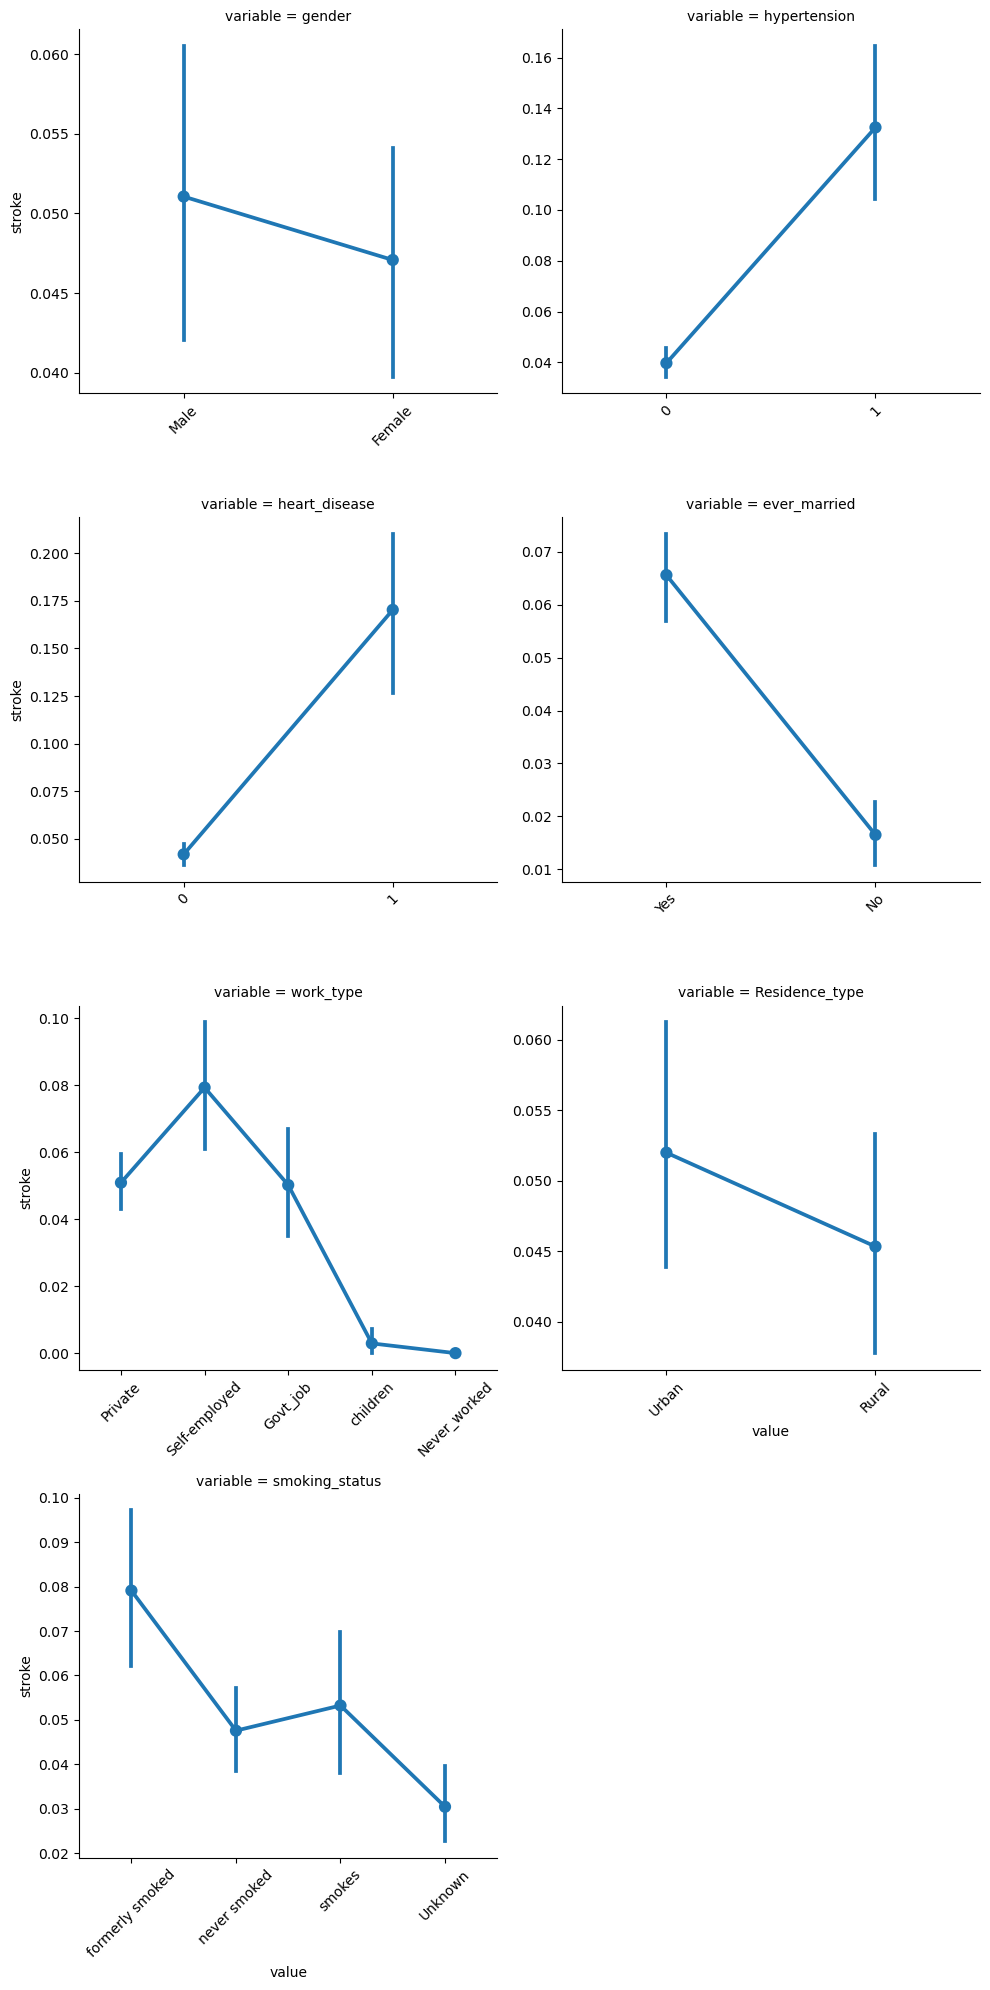

In [17]:
g=sns.catplot(
    x='value',
    y='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes([object, int])
    ),
    col='variable',
    kind='point',
    col_wrap=2,
    sharex=False,
    sharey=False,
)
g.set_xticklabels(rotation=45)
g.tight_layout();

Что интересного можно увидеть из этих графиков:
- вероятность инсульта у мужчин немного выше, чем у женщин
- у пациентов с гипертонией вероятность инсульта примерно в 3 раза выше
- у пациентов с сердечными заболеваниями вероятность инсульта тоже примерно в 3 раза выше
- те, кто никогда не состоял в браке, заболевают инсультом более чем в 3 раза реже
- наиболее часто инсульт встречается у частных предпринимателей и почти не встречается у тех, кто не работает
- бывшие курильщики больше других подвержены инсультам (даже больше чем курящие)
- живущие в городе чуть чаще подвержены инсультам

Рассмотрим, как выглядят признаки по половому различию

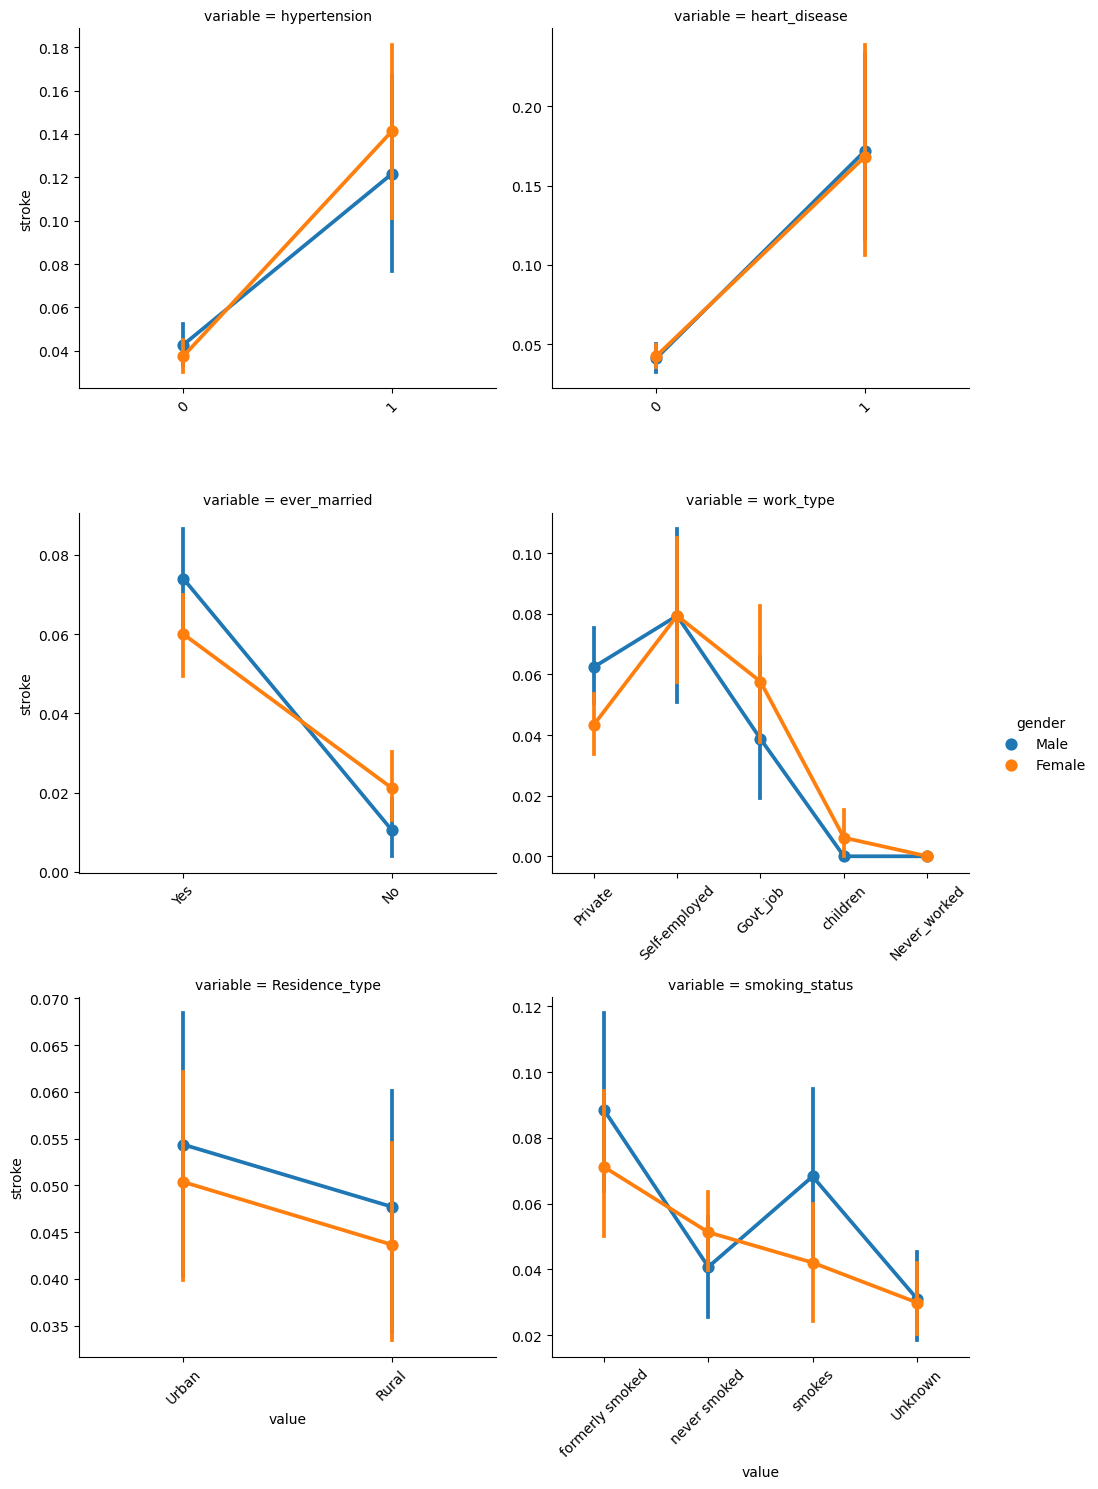

In [18]:
g=sns.catplot(
    x='value',
    y='stroke',
    data=stroke.melt(
        id_vars=['stroke', 'gender'],
        value_vars=stroke.select_dtypes([object, int])
    ),
    col='variable',
    hue='gender',
    kind='point',
    col_wrap=2,
    sharex=False,
    sharey=False,
)
g.set_xticklabels(rotation=45)
g.tight_layout();

Ничего существенного!

Теперь рассмотрим как распределены количественные признаки

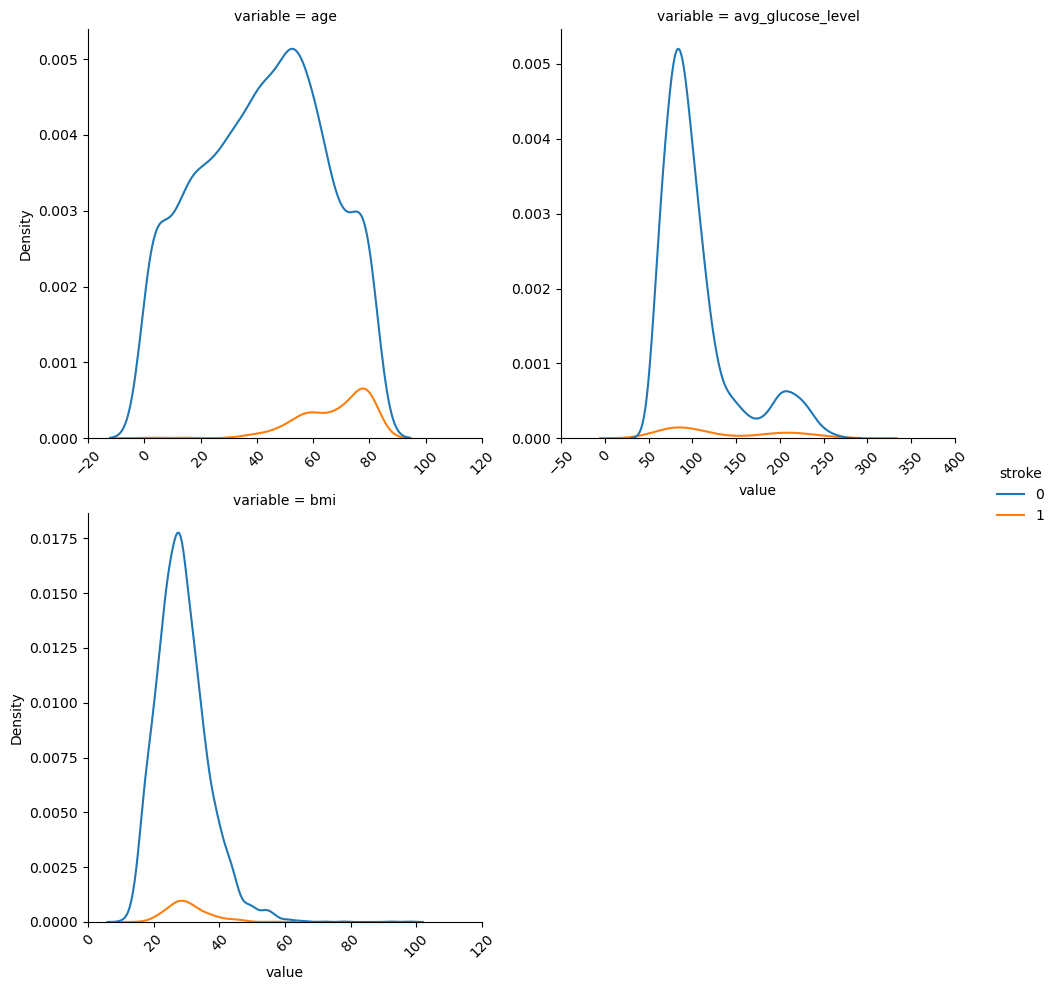

In [19]:
g=sns.displot(
    x='value',
    hue='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes(float)
    ),
    col='variable',
    kind='kde',
    col_wrap=2,
    facet_kws=dict(sharex=False, sharey=False)
)
g.set_xticklabels(rotation=45)
g.tight_layout();

Что интересного можного увидеть из этих графиков:
- по индексу **bmi** сколь значимого отличия нет, там и там максимум приходится примерно на 30
- по среднему уровню глюкозы в крови наблюдаются два пика
- а вот по возрасту у пациентов с инсультом видно чёткое смещение пика к 80 годам

Давайте рассмотрим парные графики

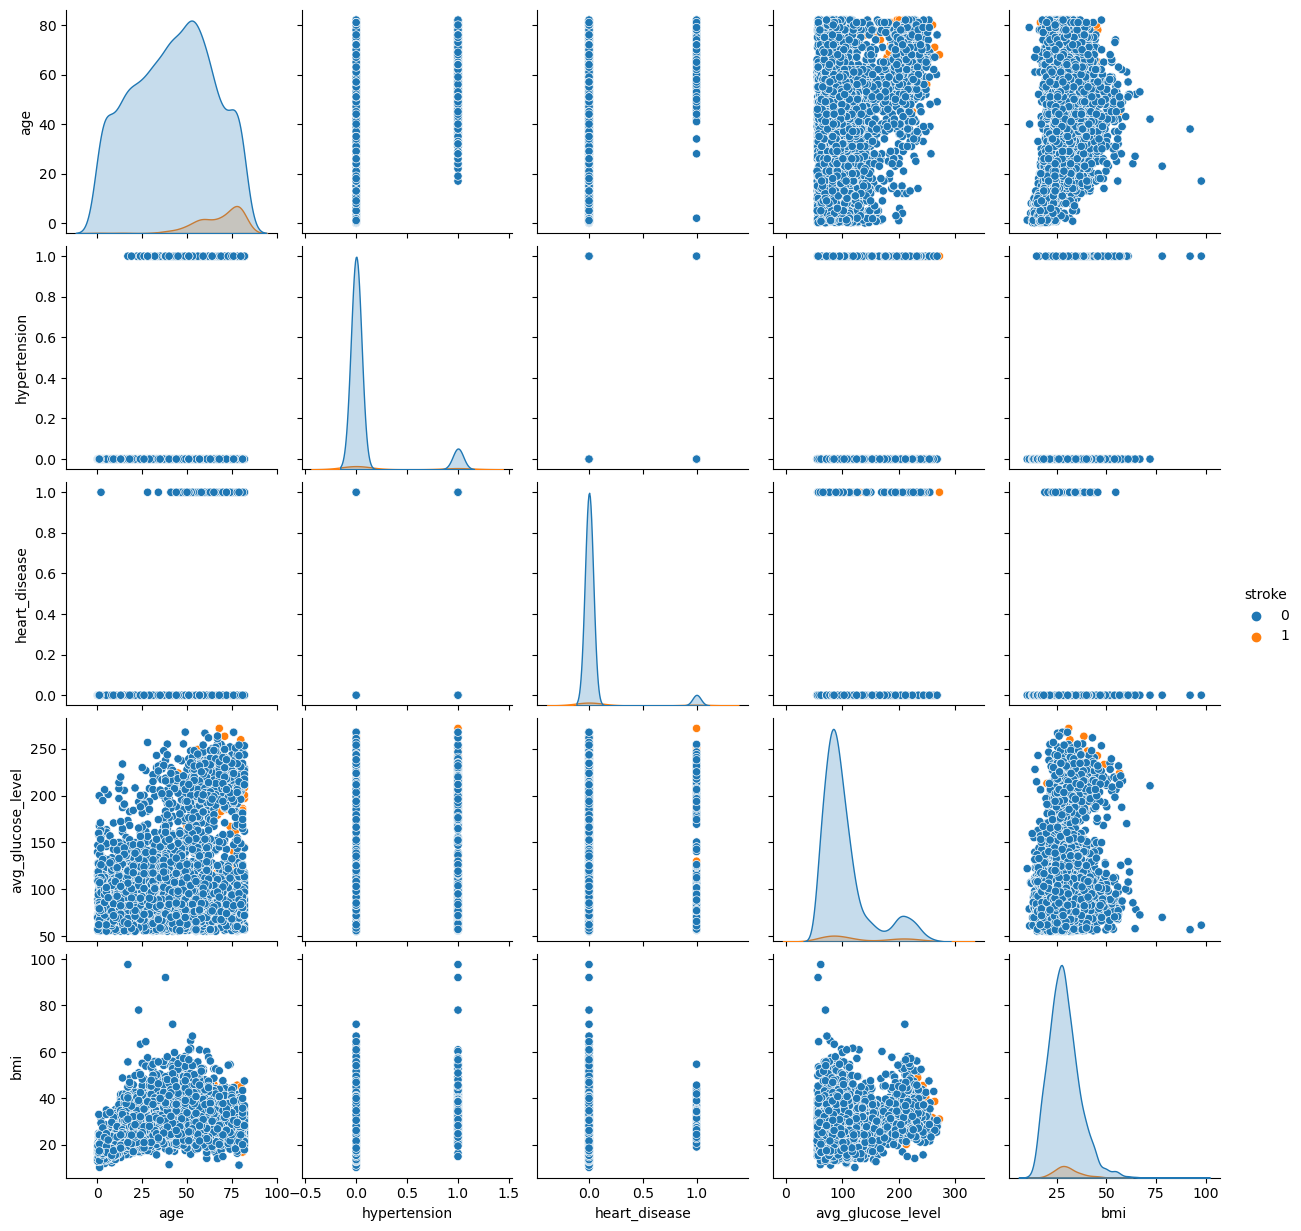

In [20]:
sns.pairplot(stroke, hue='stroke');

К сожалению, разделение по целевому признаку видно плохо. Рассмотрим некоторые графики подробнее

In [21]:
def plot_stroke(x, y, alpha_1=0.2, alpha_2=0.5):
    plt.plot(stroke[stroke.stroke==0][x], stroke[stroke.stroke==0][y], 'bo', label='no stroke', alpha=alpha_1)
    plt.plot(stroke[stroke.stroke==1][x], stroke[stroke.stroke==1][y], 'r^', label='stroke', alpha=alpha_2)
    plt.grid(True, which='both')
    plt.legend(loc='center right', fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12, rotation=90);

Рассмотрим, как связаны возраст пациента, заболевания сердца и инсульт

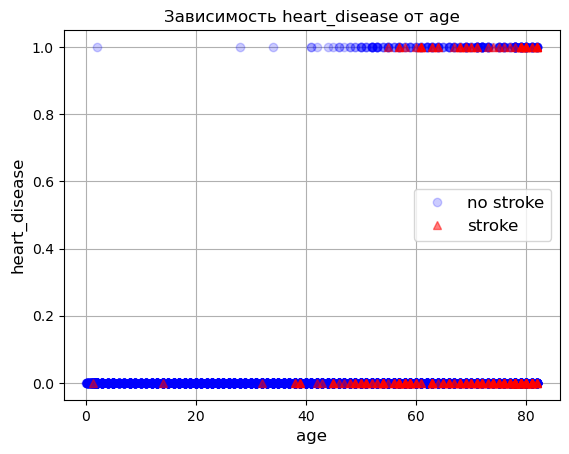

In [22]:
plot_stroke('age', 'heart_disease')
plt.title('Зависимость heart_disease от age');

Видна интересная особенность - у группы пациентов, у которых отсутствуют заболевания сердца, инсульт начинает встречаться с 40 лет! А у пациентов с заболеваниями сердца - ближе к 60 годам. 

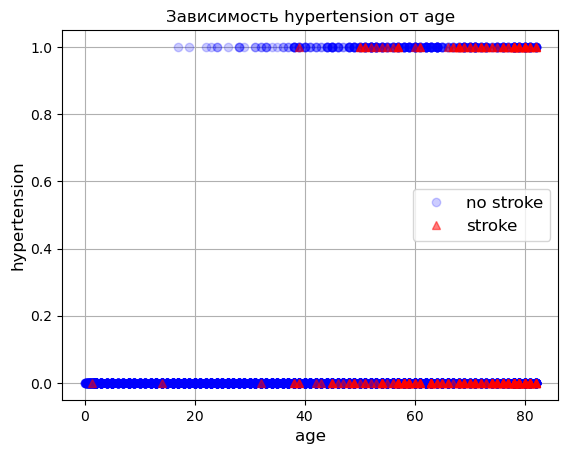

In [23]:
plot_stroke('age', 'hypertension')
plt.title('Зависимость hypertension от age');

Примерно схожая картина наблюдается у пациентов с гипертонией. Здесь также инсульт начинает проявляться примерно с 40 лет у здоровых пациентов, и с 50 лет у пациентов с гипертонией

Теперь рассмотрим как связаны между собой индекс массы тела, возраст и глюкоза в крови

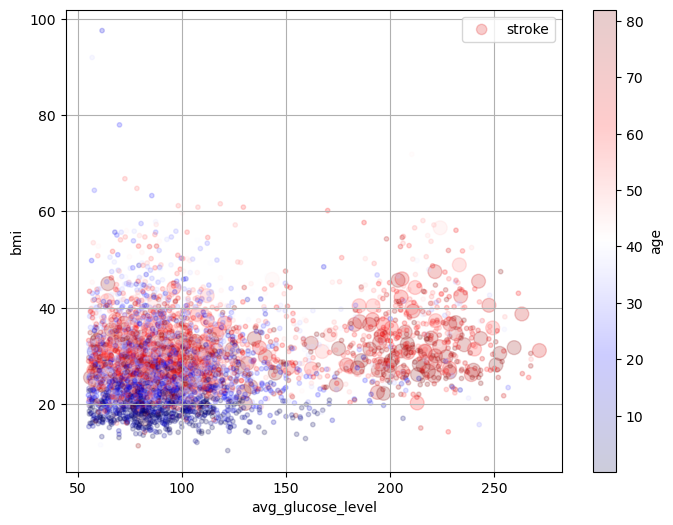

In [24]:
stroke.plot(
    kind='scatter', 
    x='avg_glucose_level', 
    y='bmi', 
    alpha=0.2,             
    label='stroke', 
    figsize=(8,6),
    c='age', 
    s=stroke.stroke.map(lambda x: 100 if x else 10),
    cmap='seismic',
    colorbar=True,
    grid=True,
    sharex=False)
plt.legend();

Отчётливо видно 2 скопления - левее и правее уровня глюкозы 150-170. Причём если справа в основном всё красное, то слева смесь и красного и синего цвета. Получается, что повышенный уровень глюкозы характерен для возраста старше 40 лет. Видно также небольшое повышение ИМТ с возрастом. При этом пациенты с инсультом есть и слева и справа.  

Если посмотреть только на пациентов с инсультом, то видно, что они в основном старше 50 лет и распределены примерно поровну по двум группам. При этом виден рост ИМТ.

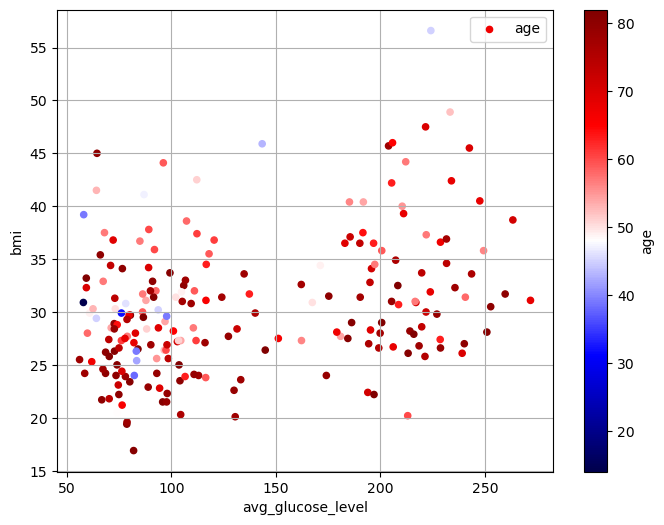

In [25]:
stroke[stroke.stroke==1].plot(
    kind='scatter', 
    x='avg_glucose_level', 
    y='bmi', 
    label='age', 
    figsize=(8,6),
    c='age', 
    cmap='seismic',
    colorbar=True,
    grid=True,
    sharex=False)
plt.legend();

И напоследок рассмотрим, как распределён инсульт по возрастным группам

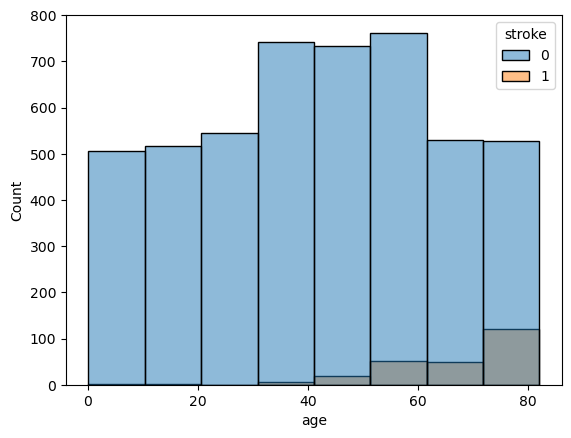

In [26]:
sns.histplot(
    x='age',
    data=stroke,
    hue='stroke',
    bins=8
);

Как видно, инсульт начинается проявляться после 40 лет, затем наблюдается рост после 50 лет, а потом после 70. При этом пациентов после 60 лет наблюдается меньше - то есть получается рост не только в абсолютных значениях, но и в относительных!

## 5. Моделирование <a class="anchor" id="5"></a>
[Наверх](#0)

Для того, чтобы в дальнейшем понять, что мы движемся в верном направлении, получим базовые оценки на текущих данных. Но сначала вспомним, что категориальные признаки **gender**, **ever_married**, **Residence_type** имеют всего 2 варианта значений. Преобразуем их

In [27]:
stroke.gender = stroke.gender.map(lambda x: 1 if x == 'Male' else 0)
stroke.ever_married = stroke.ever_married.map(lambda x: 1 if x == 'Yes' else 0)
stroke.Residence_type = stroke.Residence_type.map(lambda x: 1 if x == 'Urban' else 0)

Разделим наш датасет на тестовый и тренировочный в соотношении 1/5. При этом стратифицируем выборку по целевому параметру, так как интересующих нас значений немного (примерно 5%)

In [28]:
stroke_train, stroke_test = train_test_split(stroke, test_size=0.2, random_state=42, stratify=stroke.stroke)

Также вспомним, что у признака **bmi** есть пропущенные значения. Заполним эти пропуски

In [29]:
stroke_train.bmi = stroke_train.bmi.fillna(stroke_train.bmi.mean())

Выделим метки

In [30]:
X_train = stroke_train.drop(['stroke'], axis=1)
y_train = stroke_train.stroke.copy()

In [31]:
cat_columns = X_train.select_dtypes(object).columns

In [32]:
num_columns = X_train.select_dtypes(exclude=object).columns

Закодируем категориальные значения и нормализуем числовые

In [33]:
prep = ColumnTransformer([
    ('cat', OneHotEncoder(sparse=True, handle_unknown='ignore'), cat_columns),
    ('num', StandardScaler(), num_columns),
])

In [34]:
X_train_encoded = prep.fit_transform(X_train)

In [35]:
def make_scores(y_train, y_pred):
    scores = {
        'accuracy_score': f'{accuracy_score(y_train, y_pred):0.3f}',
        'precision_score': f'{precision_score(y_train, y_pred):0.3f}',
        'recall_score': f'{recall_score(y_train, y_pred):0.3f}',
        'f1_score': f'{f1_score(y_train, y_pred):0.3f}'
    }
    return scores

Определим несколько классификаторов, зададим балансировку (так как у нас явный дисбаланс классов)

In [36]:
log_clf = LogisticRegression(random_state=42, class_weight='balanced')
svm_clf = SVC(random_state=42, probability=True, class_weight='balanced')
tre_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
rnd_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb_clf = XGBClassifier(random_state=42, verbosity=0, scale_pos_weight=19)
lgb_clf = LGBMClassifier(random_state=42, class_weight='balanced')

Чтобы понять, не переучились ли наши модели, воспользуемся кросс-валидацией по 4-м фолдам. При этом, чтобы получить
значение _ROC-AUC_, нужно получить вероятности предсказания классов

In [37]:
metrics = {}
for clf in (
    log_clf, 
    svm_clf,
    tre_clf, 
    rnd_clf,
    xgb_clf,
    lgb_clf
    ):
    y_train_score = cross_val_predict(clf, X_train_encoded, y_train, cv=4, n_jobs=-1, method='predict_proba')
    metrics[clf.__class__.__name__] = {'roc_auc': roc_auc_score(y_train, y_train_score[:, 1])}

In [38]:
for clf in (
    log_clf, 
    svm_clf,
    tre_clf, 
    rnd_clf,
    xgb_clf,
    lgb_clf
    ):
    y_train_pred = cross_val_predict(clf, X_train_encoded, y_train, cv=4, n_jobs=-1, method='predict')
    metrics[clf.__class__.__name__] = (metrics[clf.__class__.__name__] | make_scores(y_train, y_train_pred))

In [39]:
pd.DataFrame(metrics).T.apply(pd.to_numeric).style.format('{:.3f}').background_gradient(cmap=plt.get_cmap('PuBu'), axis=0)

,roc_auc,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression,0.836,0.744,0.136,0.799,0.233
SVC,0.765,0.764,0.113,0.563,0.189
DecisionTreeClassifier,0.554,0.922,0.164,0.146,0.154
RandomForestClassifier,0.803,0.950,0.143,0.005,0.010
XGBClassifier,0.811,0.930,0.217,0.166,0.188
LGBMClassifier,0.824,0.910,0.185,0.251,0.213


Как видно, лучшие результаты по _ROC-AUC_ дали **LogisticRegression** и **LightGBM**

**Построим кривые _ROC_**

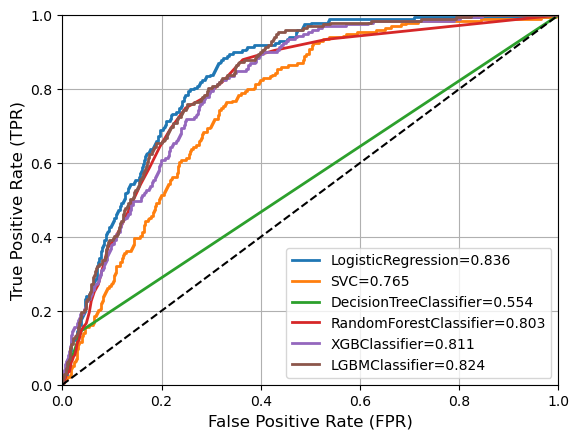

In [40]:
colors = ['k', 'r', 'y', 'g', 'b', 'm']
clfs = [log_clf, svm_clf, tre_clf, rnd_clf, xgb_clf, lgb_clf]
for clf, color in zip(clfs, colors):
    y_prob = cross_val_predict(clf, X_train_encoded, y_train, cv=4, n_jobs=-1, method='predict_proba')
    fpr, tpr, _ = roc_curve(y_train, y_prob[:, 1])
    plt.plot(fpr, tpr, linewidth=2, label=f'{clf.__class__.__name__}={roc_auc_score(y_train, y_prob[:, 1]):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.legend()
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.grid(True)

Прежде чем проверить наши модели на тестовой выборке, посмотрим, есть ли выбросы среди числовых признаков. Воспользуемся "ящиком с усами"

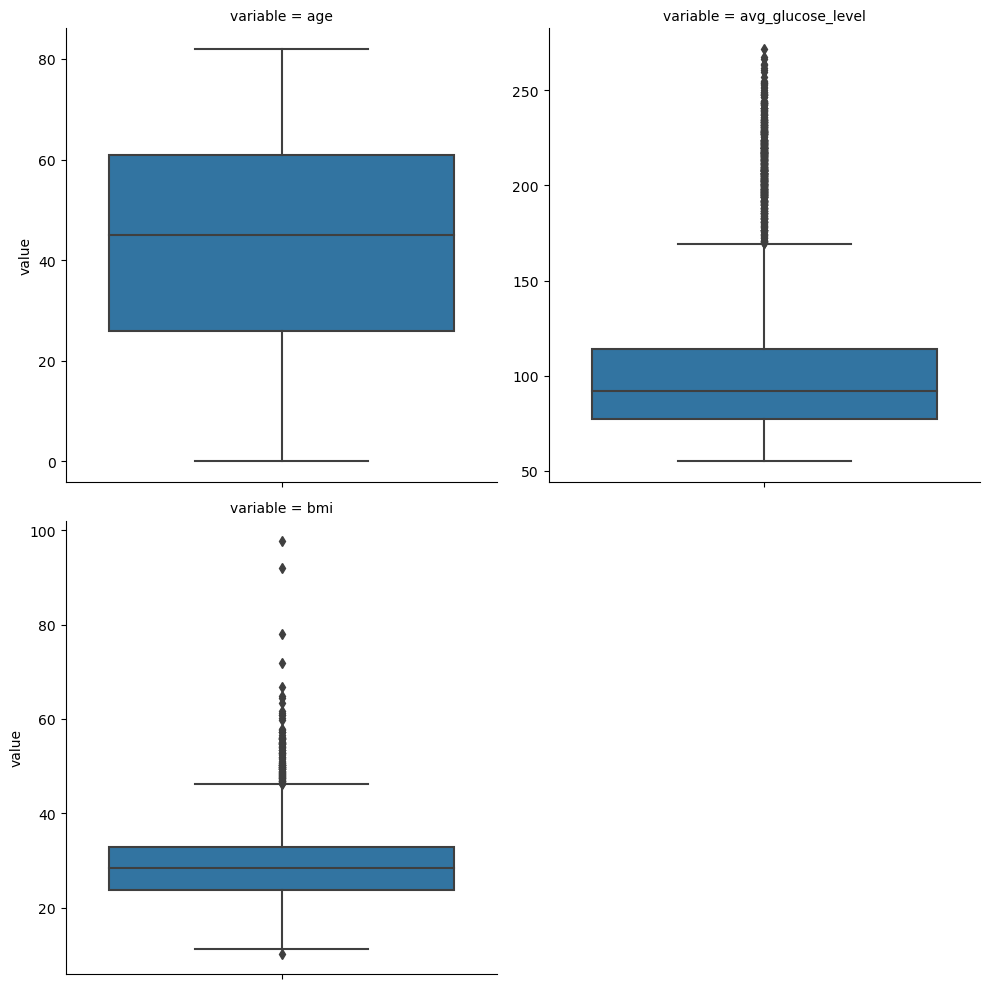

In [41]:
g=sns.catplot(
    y='value',
    data=stroke_train.melt(
        id_vars=['stroke'],
        value_vars=stroke_train.select_dtypes(float)
    ),
    col='variable',
    kind='box',
    col_wrap=2,
    sharex=False, 
    sharey=False,
)

Как видно, есть довольно много выбросов у **bmi** и **avg_glucose_level**. Посмотрим, как распределены эти выбросы по классам

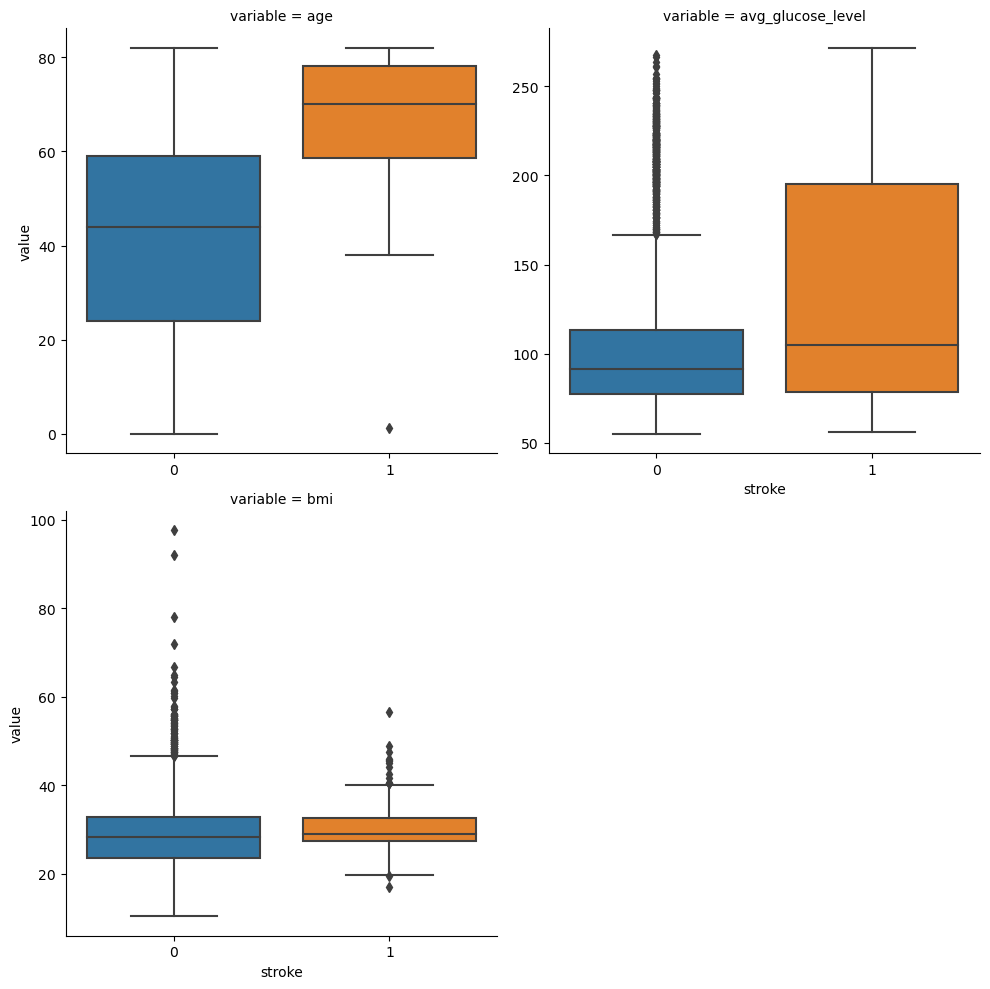

In [42]:
g=sns.catplot(
    y='value',
    x='stroke',
    data=stroke_train.melt(
        id_vars=['stroke'],
        value_vars=stroke_train.select_dtypes(float)
    ),
    col='variable',
    kind='box',
    col_wrap=2,
    sharex=False, 
    sharey=False,
)

Получили интересную картину: значения **avg_glucose_level**, которые для положительного класса явялется нормальными, для отрицательного являются выбросами. И немного похожая картина наблюдается для **bmi**. На первый взгляд, логичным решением было бы удалить выбросы отдельно для каждого класса. Но тогда непонятно как поступить в таком случае с тестовыми данными, где мы не можем обратиться к классам. Поэтому выбросы пока не трогаем! 

Теперь проверим наши модели с базовыми параметрами на тестовых данных. Но сначала необходимо подготовить их

Заполним пропуски

In [43]:
stroke_test.bmi = stroke_test.bmi.fillna(stroke_train.bmi.mean())

Выделим метки

In [44]:
X_test = stroke_test.drop(['stroke'], axis=1)
y_test = stroke_test.stroke.copy()

Закодируем категориальные переменные

In [45]:
X_test_encoded = prep.transform(X_test)

In [46]:
metrics_test = {}
for clf in (
    log_clf, 
    svm_clf,
    tre_clf, 
    rnd_clf,
    xgb_clf,
    lgb_clf
    ):
    clf.fit(X_test_encoded, y_test)
    y_test_score = clf.predict_proba(X_test_encoded)
    metrics_test[clf.__class__.__name__] = {'roc_auc': roc_auc_score(y_test, y_test_score[:, 1])}

In [47]:
for clf in (
    log_clf, 
    svm_clf,
    tre_clf, 
    rnd_clf,
    xgb_clf,
    lgb_clf
    ):
    clf.fit(X_test_encoded, y_test)
    y_test_pred = clf.predict(X_test_encoded)
    metrics_test[clf.__class__.__name__] = (metrics_test[clf.__class__.__name__] | make_scores(y_test, y_test_pred))

In [48]:
(pd.DataFrame(metrics_test).T.apply(pd.to_numeric)
 .style.format('{:.3f}').background_gradient(cmap=plt.get_cmap('PuBu'), axis=0))

,roc_auc,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression,0.852,0.739,0.137,0.820,0.235
SVC,0.957,0.881,0.283,0.940,0.435
DecisionTreeClassifier,1.000,1.000,1.000,1.000,1.000
RandomForestClassifier,1.000,1.000,1.000,1.000,1.000
XGBClassifier,1.000,1.000,1.000,1.000,1.000
LGBMClassifier,1.000,1.000,1.000,1.000,1.000


Ого! Четыре классификатора из шести дали 100-процентное предсказание. Причём точность на тестовой выборке оказалась выше, чем на тренировочной!

Отобразим прирост метрик в процентах

In [49]:
def diff_metrics(a, b):
    a1 = pd.DataFrame(a).apply(pd.to_numeric)
    b1 = pd.DataFrame(b).apply(pd.to_numeric)
    columns = a.keys()
    index = list(a.values())[0].keys()
    diff = pd.DataFrame((a1.values - b1.values)/b1.values*100, columns=columns, index=index)
    return diff.T.style.format('{:.2f}').background_gradient(cmap=plt.get_cmap('coolwarm'), axis=None, vmin=-10, vmax=10)

In [50]:
diff_metrics(metrics_test, metrics)

,roc_auc,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression,1.95,-0.67,0.74,2.63,0.86
SVC,25.14,15.31,150.44,66.96,130.16
DecisionTreeClassifier,80.56,8.46,509.76,584.93,549.35
RandomForestClassifier,24.51,5.26,599.30,19900.00,9900.00
XGBClassifier,23.31,7.53,360.83,502.41,431.91
LGBMClassifier,21.31,9.89,440.54,298.41,369.48


Как видно, лучшие показатели у классификаторов на основе деревьев. Худший результат показал линейный классификатор (логистическая регрессия)

Попробуем интерпретировать наши модели при помощи [SHAP](https://shap-lrjball.readthedocs.io/en/latest/index.html)

## 6. Интерпретация <a class="anchor" id="6"></a>
[Наверх](#0)

Импортируем модуль **SHAP**

In [51]:
import shap

In [52]:
shap.initjs()

Для того, чтобы понять, как работают наши модели, выберем случайным образом из тестовой выборки два элемента, у которых целевой признак равен 0 и два, у которых равен 1 

In [60]:
np.random.seed(42)
idx1 = np.random.choice(stroke_test[stroke_test.stroke==0].index, 2)
idx2 = np.random.choice(stroke_test[stroke_test.stroke==1].index, 2)
idx = idx1.tolist() + idx2.tolist()
idx = stroke_test.index.get_indexer(idx).tolist()

Попробуем объяснить поведение нашей модели на примере _XGBoostClassifier_

In [64]:
explainer = shap.TreeExplainer(xgb_clf)
shap_train_values = explainer.shap_values(X_train_encoded, y_train)
shap_test_values = explainer.shap_values(X_test_encoded, y_test)

In [65]:
shap_train_encoded = pd.DataFrame(shap_train_values, index=X_train.index, columns=prep.get_feature_names_out())
shap_test_encoded = pd.DataFrame(shap_test_values, index=X_test.index, columns=prep.get_feature_names_out())

Оценим влияние признаков

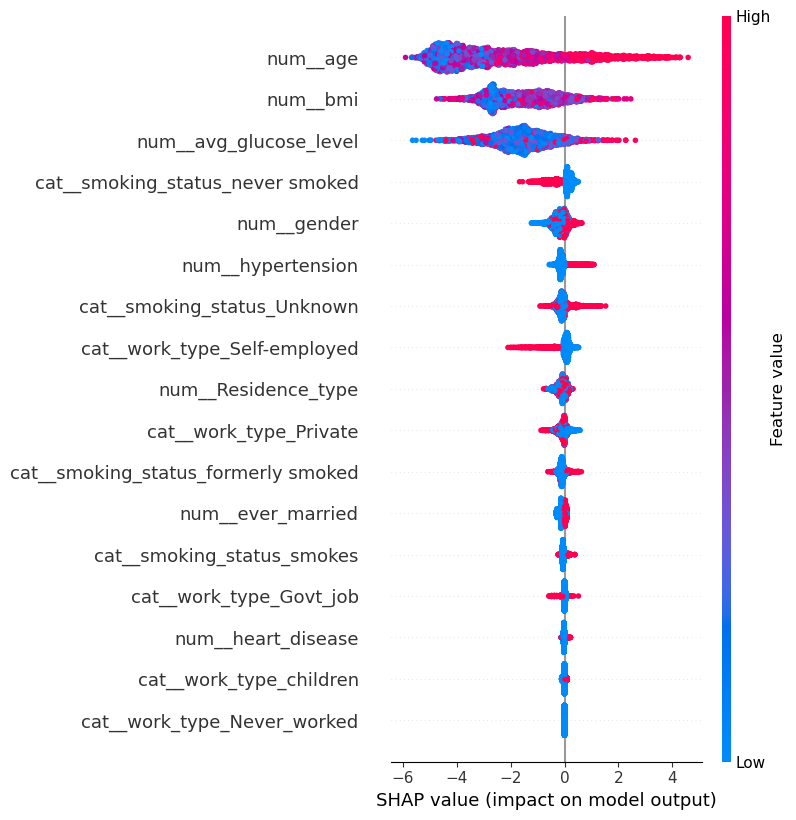

In [66]:
shap.summary_plot(shap_train_values, X_train_encoded, prep.get_feature_names_out())

Как видно, модель в основном опирается на три признака: **age**, **avg_glucose_level** и **bmi**. Причём связь инсульта с **age** прямая, а с **bmi** - неоднозначная. Скорей всего его нужно рассматривать в совокупности с другими признаками. Низкий уровень **avg_glucose_level** понижает вероятность инсульта. Остальные признаки менее значимы (хотя и могут сыграть важную роль при определенном стечении)

Выведем зависимости для **bmi** и **avg_glucose_level**

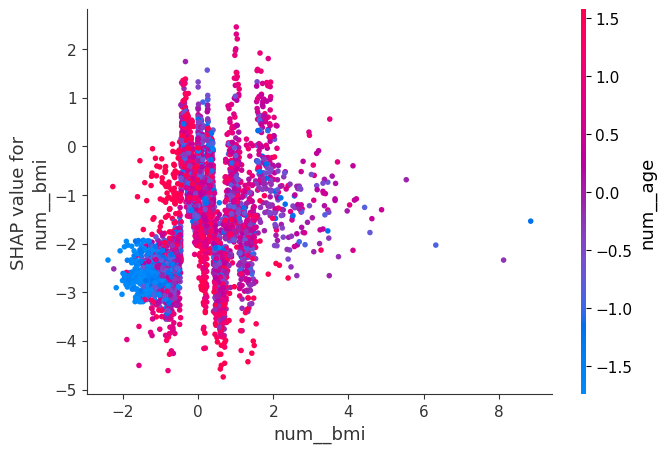

In [67]:
shap.dependence_plot('num__bmi', shap_train_values, X_train_encoded, prep.get_feature_names_out())

Видно, что для пациентов с нормальным **bmi** старшего возраста инсульт не характерен. Зато характерен для более молодых пациентов 

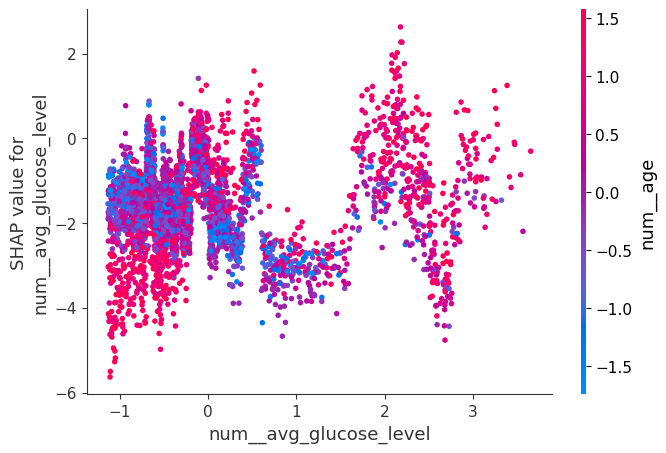

In [68]:
shap.dependence_plot('num__avg_glucose_level', shap_train_values, X_train_encoded, prep.get_feature_names_out())

На данном графике можно увидеть, что с ростом **avg_glucose_level** повышается вероятность инсульта для пациентов старшего возраста

Попробуем взять несколько значений из тестового набора и посмотрим, как модель принимает своё решение 

In [69]:
stroke_test.iloc[[idx[0]]]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2296,0,47.0,0,0,1,Govt_job,1,95.07,38.8,formerly smoked,0


In [70]:
shap.force_plot(explainer.expected_value, shap_test_values[idx[0]], features=shap_test_encoded.iloc[idx[0], :])

_У пациента средний возраст, нормальный уровень глюкозы, но масса тела повышенная (хотя в данном случае она "играет" не в пользу инсульта)_

In [71]:
stroke_test.iloc[[idx[1]]]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4804,0,39.0,0,0,0,Private,0,79.0,30.0,never smoked,0


In [72]:
shap.force_plot(explainer.expected_value, shap_test_values[idx[1]], features=shap_test_encoded.iloc[idx[1], :])

_У данного пациента вообще отсутствуют негативные факторы_

In [73]:
stroke_test.iloc[[idx[2]]]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
245,0,14.0,0,0,0,children,0,57.93,30.9,Unknown,1


In [74]:
shap.force_plot(explainer.expected_value, shap_test_values[idx[2]], features=shap_test_encoded.iloc[idx[2], :])

_Здесь у нас очень молодой пациент, но с повышенным **bmi**_ для данного возраста

In [75]:
stroke_test.iloc[[idx[3]]]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
80,1,59.0,0,0,1,Private,0,96.16,44.1,Unknown,1


In [76]:
shap.force_plot(explainer.expected_value, shap_test_values[idx[3]], features=shap_test_encoded.iloc[idx[3], :])

_Данный пациент старшего возраста и с высоким **bmi**_

## 7. Заключение <a class="anchor" id="7"></a>
[Наверх](#0)

В данной работе мы пытались предсказать у пациентов инсульт и объяснить данное предсказание с помощью значений Шепли ([Shapley](https://en.wikipedia.org/wiki/Lloyd_Shapley)). Другими словами, нам предстояло решить задачу бинарной классификации. Для этого применялись различные модели. Наилучший результат показали модели на основе деревьев. Причём на тестовой выборке удалось добиться точности 100 %. При этом нам даже не пришлось чистить исходный датасет и создавать новые признаки. Так же не потребовался тюнинг моделей.